# 各 Twitter 所提到 CVE 的箱型圖
#### 箱型圖的繪製。
##### 參考來源：http://stackoverflow.com/questions/29647145/setting-flier-outlier-style-in-seaborn-boxplot-is-ignored
#### 每個 dict 中的元素長度必須相同，所以必須將沒有資料的欄位填上 NaN。
##### 參考來源：http://stackoverflow.com/questions/19736080/creating-dataframe-from-a-dictionary-where-entries-have-different-lengths

In [1]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")
import pyes
from datetime import datetime
from calendar import monthrange

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)

Month_Twitter = dict()
Month_Tweets = dict()

# 用來把簡單的時間轉換成超複雜的Twitter用時間
def dtConvert(s):
    date_object = datetime.strptime(s, '%Y %m %d %X') # 定義輸入進來的簡單時間格式
    dt_str = date_object.ctime() # 把格式轉換成 Twitter 的 G8 時間格式(但時區未包含在內)
    dt_list = dt_str.split() # 為了把時區塞進去，要先把 String 切成 list
    dt_list.insert(4, '+0000') # 在 list 中的第四個位置塞入時區資料
    dt_result = ' '.join(dt_list) # 把 list 轉回 string 並以空白區隔
    return dt_result # 完成並回傳結果

# 將某月的資料爬出來並計算結果
def queryResult(Sfrom, Sto, Y, M):
    q = pyes.query.BoolQuery()
    ESR = pyes.ESRange(field="created_at", from_value=Sfrom, to_value=Sto, include_lower=True ,include_upper=True)
    rq = pyes.query.RangeQuery(qrange=ESR)
    tq = pyes.query.TermQuery(field="text", value="cve")

    q.add_must(tq)
    q.add_must(rq)
    result = None
    result = conn.search(query=q , indices='twitter2' , doc_types='tweet') 
    
    # 將每個月的 Tweets 數量寫入 dict。
    if M in Month_Tweets:
        Month_Tweets[M].append(len(result))
    else:
        Month_Tweets[M] = [len(result)]

    # 將每個月的 Twitter 數量寫入 list。
    storage = set() # 用 set 來儲存不重複的元素。
    for x in result:
        if 'uid' in x:                          # 2014年7月有一筆資料的 uid Missing，所以用 if 來處理並忽略。
            storage.add(x['uid'])
    if M in Month_Twitter:
        Month_Twitter[M].append(len(storage))
    else:
        Month_Twitter[M] = [len(storage)]
    return

# 主程式
# 資料從2008年2月1日開始到2015年7月31日
for y in range(2008, 2016):
    for m in range(1, 13):
        if y == 2008 and m < 2:
            None
        elif y == 2015 and m > 7:
            None
        else:
            dt_from = [y, m, '1', '00:00:00']
            dt_to = [y, m, monthrange(y, m)[1], '23:59:59']
            Sdt_from = dtConvert(' '.join(str(v) for v in dt_from))
            Sdt_to = dtConvert(' '.join(str(v) for v in dt_to))
            queryResult(Sdt_from, Sdt_to, y, m)

# 輸出結果矩陣
df1 = pd.DataFrame(dict([(k,Series(v)) for k,v in Month_Tweets.iteritems()])) # 將沒有資料的欄位填上 NaN
df2 = pd.DataFrame(dict([(k,Series(v)) for k,v in Month_Twitter.iteritems()])) # 將沒有資料的欄位填上 NaN
print df1, "\n"
print df2

     1   2   3   4   5   6   7     8     9     10    11    12
0   0.0   0   0   0   0   0   1   0.0   0.0   0.0   0.0   0.0
1   1.0   0   0   0   0   0   0   0.0   0.0   0.0   1.0   0.0
2   1.0   0   1   0   0   2   1   0.0   3.0   1.0   0.0   1.0
3   5.0   1   0   2   0   0   1   0.0   2.0   2.0   0.0   1.0
4   2.0   3   1   2   1   2   2   4.0   0.0   0.0   0.0   0.0
5   5.0   3   0   4   4   7   1   3.0   4.0  15.0  14.0   4.0
6  27.0  17  19  21  17  15  10  12.0  55.0  56.0  27.0  11.0
7   NaN  26  52  35  21  61  54   NaN   NaN   NaN   NaN   NaN 

     1   2   3   4   5   6   7    8     9     10    11   12
0   0.0   0   0   0   0   0   1  0.0   0.0   0.0   0.0  0.0
1   1.0   0   0   0   0   0   0  0.0   0.0   0.0   1.0  0.0
2   1.0   0   1   0   0   1   1  0.0   3.0   1.0   0.0  1.0
3   2.0   1   0   2   0   0   1  0.0   2.0   1.0   0.0  1.0
4   2.0   3   1   2   1   1   1  2.0   0.0   0.0   0.0  0.0
5   3.0   2   0   4   4   4   1  3.0   3.0   8.0  11.0  3.0
6  15.0  10  10  13 

//anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


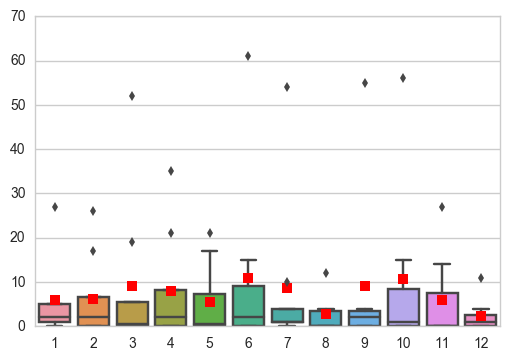

In [2]:
%matplotlib inline
ax = sb.boxplot(df1, vert=True, showmeans=True)

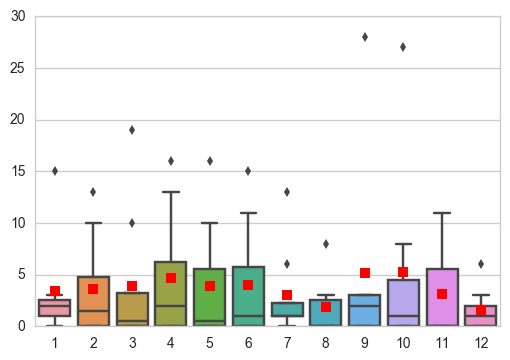

In [3]:
%matplotlib inline
ax = sb.boxplot(df2, vert=True, showmeans=True)